# Regression in terms of Trees and Forests

### **Group 3:** _Ashish Agarwal, Bagal Satej Babanrao, Kushagra Mahajan, Mihir Yadav, Mriganka Basu Roy Chowdhury_

Over the last few decades, the statistical learning/inference community has experienced a boom. With the advent of AI/ML, people have increasingly turned to sophisticated methods like Deep Learning and Reinforcement Learning. However, for a wide range of tasks of practical use, "classical" algorithms still fare sufficiently well. And what is more important -- the theory of these classical estimators is fairly well understood. We now know how they work, why they work, and how they can be modified effectively and deterministically for various use-cases. This makes their study not only relevant from a historical perspective, but also from a scientific perspective because they form that part of a data-scientists toolbox where he/she is aware of the underlying theory (as opposed to DL, which is still mostly a black-box), and consequently can wield them to considerable effect.

The most popular and well studied of these classical estimators/classifiers is perhaps Regression (and its many variants). In this article we delve deeper into a form of Regression that uses Decision Trees, an extremely powerful idea in Classical ML. Towards the end of this article we will also take a look at simple ensemble methods, like the Random Forest.



## Decision Trees

What are decision trees? Perhaps we are better off answering this with a picture:

![](https://github.com/mbrc12/random-images/raw/master/decisionTree.png)

We think of $A, B, C$ as attributes of a data-point. Each node represents a question (say $A < B$ ?,  $A + 2B > 9$ ? etc) which has TRUE/FALSE answer. The two edges out of the node represent these two answers. Each leaf will essentially represent a set of inequalities. This means that a leaf node corresponds to the region (in the domain) defined by these inequalities; like the following figure:

![](https://github.com/mbrc12/random-images/raw/master/splitting.png)

### Regression

The decision tree will split the dataset into many parts, by determining optimal attributes and corresponding splitting values. Given a new datapoint, we can now figure out to which leaf this point belongs and report the average of the decision values of all the datapoints belonging to this leaf.

Why are decision trees better than simple regression? Well consider the following data-points:

![](https://github.com/mbrc12/random-images/raw/master/comparison_with_linear_regression.png)

As we can see, there are different regions with different characteristics. If we used plain linear regression, it would attempt to treat these differing regions as the same, thereby causing a large error (on both test and training data), simply because it is not capable of capturing this feature of a dataset. Decision trees however can divide the plane into regions and fit different structures on different parts, thereby giving a much better accuracy. This theoretical prediction is indeed also carried over in practice. 

## Constructing the Decision Tree
The central idea lies in how we split a given node. We iterate over all the features and calculate the splitting value and impurity corresponding to that feature and **select the one providing the minimum impurity**, which is defined as the <b>weighted sum of the sample variances of the two child nodes</b>. This can be calculated by first sorting all the datapoints present in that node based on the corresponding feature values and then making a linear traversal.

Initially we would place all the points in the right child. At every step, we would move the current datapoint from the right node to the left node and make the required changes in the sample variances of the children nodes.

So how can we actually construct such a tree?
The crux of the algorithm lies in coming up with the best splits at each node. The splits are identified with the sole purpose of minimizing the impurity at the nodes.

Now how to define this 'impurity' given a set of data points at a node?

For regression purposes variance of the data has proved to be a good measure of impurity. For our use case we find the split that minimizes the weighted sum of variance at each child node generated.

At each step we choose a leaf $v_{i}$ and for each attribute $d_{i}$ we calculate a constant $c_{i}$ which is the split value that results in minimum impurity if the split is made on this attribute.
This means that if a node is split at attribute $d_{i}$ with the split value $c_{i}$, the node will be split into leaves one with values $x_{d_{i}} \le c_{i}$ and the other with $x_{d_{i}} > c_{i}$.

At this point we make a core observation: 
<b>An optimal $c$ for any attribute $d$ can be chosen to be one of the $(x_{i})_{d} $</b>.

Why does this hold? <br>
Suppose the values of $(x_{i})_{k}$ are sorted as $z_{1}\le z_{2}\le z_{3} \le \cdots \le z_{N}$ where $N$ is the number of datapoints.
For a split value $c$ such that $z_{i} \le c < z_{i+1}$ we have the following: all the values $\le z_{i}$ belong to the left child and the rest to the right child. But this split remains same for any value of $c$ in $[z_{i}, z_{i+1})$. So we can just take $c$ to be $z_{i}$ itself.

This makes life a bit simpler as for calculating the optimal split value for some attribute $d_{i}$ we just need to iterate over all $z_{i}$ and pick the value that results in the most variance reduction.

Now the only thing that remains is to choose an attribute to split on. This happens to be trivial as we just need to iterate over all attributes and choose the one that reduces the variance most. The optimal split for each attribute is calculated by following the steps explained above.

Okay, so far we have seen how we can grow our decision tree starting from a single root node by splitting the nodes at each iterative step. How long do we keep doing this?<br>
Should we do this till we reach pure splits and cannot split further? Then we would get $100\%$ accuracy on the training data but will most definitely end up just learning all the training data and our model will not generalize well to unseen data.

It looks like we need some stopping criterion to prevent our model from overfitting.

At this point let us introduce the $\mathrm{coefficient\ of\ variance}$: 

$\mathrm{CoefVar} = \dfrac{\mathrm{Standard\ Deviation}}{\mathrm{Mean}} = \dfrac{\sqrt{\dfrac{1}{n}\sum_{j}(y_{j}-\bar y)^{2}}}{\bar y}$

which is a measure of the variability of data relative to the mean.

At every node we calculate this coefficient and if it falls below a certain threshold, $i.e.$ the variability of data has reduced enough, the node is not split any more. 


## Code Walkthrough
We begin with a single node, and iterate over all possible attributes and threshold values ( Function _build_ beginning from _line_ _140_ _below_) and pick the split leading to the minimum impurity. Function _get_impurity_ (_line_ _65_) computes the impurity for a given attribute. Function _get_decision_value_for_feature_ (_line_ _23_) computes the threshold splitting value correspoding to a feature. Once these are evaluated, _divide_data_ (_line_ _98_) is called to make the split.

##Pruning

Pruning is yet another technique to prevent overfitting of decision trees. It reduces the size of decision trees by removing parts of the tree that do not provide enough power (as opposed to the time/overfitting cost) to classify instances. Decision trees are the most susceptible out of all the machine learning algorithms to overfitting and effective pruning can reduce this possibility.
As the name implies, pruning involves cutting back the tree. After a tree has been built (and in the absence of early stopping discussed below) it may be overfitted. The recusive algorithm will then repeatedly partition data into smaller and smaller subsets until those final subsets are homogeneous in terms of the outcome variable. In practice this often means that the final subsets (known as the leaves of the tree) each consist of only one or a few data points. The tree has learned the data exactly, but a new data point that differs very slightly might not be predicted well. This is why pruning is an important technique, in both theory and practice.

###Code Walkthrough
The code for pruning is implemented below in function `prune_decision_tree` *(line 161 - 183 below)*

* Consider an internal (non-leaf) node $v$, and let $S_v$ be the sample variance of $y_i$ of all datapoints contained in this node $v$. *(line 170 - 172)*
* Let $S_v'$ be the sum of the sample variances of $y_i$ of all leaves which are descendants of $v$. *(line 174)*
* Clearly $S_v' < S_v$, because splitting "improves" the sample variance.
* But, to penalize large structures, we look at $P_v = S_v - S_v' - \lambda |T_v|$, where $|T_v|$ is the size of the subtree of $v$, and $\lambda$ is a **pruning factor**. Larger $\lambda$ results in more pruning. *(line 176)*
* If $P_v < 0$, we decide that this subtree must be pruned. Intuitively, we prune when *pay more because of the size of the subtree than we gain because of variance reduction*. *(line 178 - 183)*

In [14]:
import numpy as np
import sklearn.metrics as metrics

class TreeNode:
    def __init__(self):
        self.predicted_value = None
        self.decision_feature = None
        self.decision_value = None
        self.left_node = None
        self.right_node = None

class DecisionTree:

    def __init__(self):
        self.root_node = None
        self.min_coef_of_var = None
        self.reductions = None

    def fit(self, X, Y, min_coef_of_var = 0, pruning_factor = 0):
        self.min_coef_of_var = min_coef_of_var
        self.root_node = self.build(X, Y)
        self.prune_decision_tree(X, Y, self.root_node, pruning_factor)

        self.reductions = np.zeros(len(X[0]))
        self.reductions = self.calculate_reductions(X, Y, self.root_node, self.reductions)

    def get_decision_value_for_feature(self, X, Y, decision_feature):
        
        Z = np.empty((0, 2), float)
        for i in range(len(Y)):
            Z = np.append(Z, [[X[i, decision_feature], Y[i]]], axis = 0)

        Z = np.sort(Z, axis = 0)

        left_cardinality = 0
        right_cardinality = 0
        left_sum = 0
        right_sum = 0
        left_sum_of_squares = 0
        right_sum_of_squares = 0

        for i in range(len(Z)):
            right_cardinality += 1
            right_sum += Z[i, 1]
            right_sum_of_squares += Z[i, 1] ** 2

        current_best_impurity = right_sum_of_squares
        current_best_decision_value = Z[0, 0] - 1

        for i in range(len(Z)):
            left_cardinality += 1
            left_sum += Z[i, 1]
            left_sum_of_squares += Z[i, 1] ** 2

            right_cardinality -= 1
            right_sum -= Z[i, 1]
            right_sum_of_squares -= Z[i, 1] ** 2

            impurity = left_sum_of_squares - left_sum * left_sum / left_cardinality
            if (right_cardinality != 0):
                impurity += right_sum_of_squares - right_sum * right_sum / right_cardinality
            
            if (impurity < current_best_impurity):
                current_best_impurity = impurity
                current_best_decision_value = Z[i, 0]

        return current_best_decision_value

    def get_impurity(self, X, Y, decision_feature, decision_value_for_feature):
        left_cardinality = 0
        right_cardinality = 0
        left_sum = 0
        right_sum = 0

        for i in range(len(Y)):
            if (X[i, decision_feature] <= decision_value_for_feature):
                left_cardinality += 1
                left_sum += Y[i]
            else:
                right_cardinality += 1
                right_sum += Y[i]

        if (left_cardinality != 0):
            left_mean = left_sum / left_cardinality
        else:
            left_mean = 0

        if (right_cardinality != 0):
            right_mean = right_sum / right_cardinality
        else:
            right_mean = 0

        impurity = 0
        for i in range(len(Y)):
            if (X[i, decision_feature] <= decision_value_for_feature):
                impurity += (Y[i] - left_mean) ** 2
            else:
                impurity += (Y[i] - right_mean) ** 2

        return impurity

    def divide_data(self, X, Y, decision_feature, decision_value):
        number_of_features = len(X[0])
        X_left = np.empty((0, number_of_features), float)
        X_right = np.empty((0, number_of_features), float)
        Y_left = np.empty(0, float)
        Y_right = np.empty(0, float)

        for i in range(len(X)):
            if (X[i, decision_feature] <= decision_value):
                X_left = np.append(X_left, [X[i]], axis = 0)
                Y_left = np.append(Y_left, [Y[i]], axis = 0)
            else:
                X_right = np.append(X_right, [X[i]], axis = 0)
                Y_right = np.append(Y_right, [Y[i]], axis = 0)

        return X_left, Y_left, X_right, Y_right

    def build(self, X, Y):
        if (len(X) == 0):
            return

        root_node = TreeNode()
        node_mean = np.mean(Y)
        root_node.predicted_value = node_mean
        node_deviation = np.std(Y)

        # Do not split
        if (node_deviation / node_mean < self.min_coef_of_var):
            root_node.decision_value = 0
            root_node.decision_feature = 0
            return

        if (np.amin(Y) == np.amax(Y)):
            root_node.decision_value = 0
            root_node.decision_feature = 0
            return root_node

        number_of_features = len(X[0])
        current_best_feature = -1
        current_best_decision_value = -1
        current_best_impurity = -1

        for i in range(number_of_features):
            decision_value_for_feature = self.get_decision_value_for_feature(X, Y, i)
            impurity_of_decision_value = self.get_impurity(X, Y, i, decision_value_for_feature)

            if (current_best_feature == -1 or impurity_of_decision_value < current_best_impurity):
                current_best_feature = i
                current_best_decision_value = decision_value_for_feature
                current_best_impurity = impurity_of_decision_value

        root_node.decision_feature = current_best_feature
        root_node.decision_value = current_best_decision_value

        X_left, Y_left, X_right, Y_right = self.divide_data(X, Y, root_node.decision_feature, root_node.decision_value)

        if (len(Y_left) == 0 or len(Y_right) == 0):
            return root_node

        root_node.left_node = self.build(X_left, Y_left)
        root_node.right_node = self.build(X_right, Y_right)
        return root_node

    def prune_decision_tree(self, X, Y, root_node, pruning_factor):
        if (root_node == None):
          return 0

        X_left, Y_left, X_right, Y_right = self.divide_data(X, Y, root_node.decision_feature, root_node.decision_value)
        left_tree_size = self.prune_decision_tree(X_left, Y_left, root_node.left_node, pruning_factor)
        right_tree_size = self.prune_decision_tree(X_right, Y_right, root_node.right_node, pruning_factor)
        tree_size = 1 + left_tree_size + right_tree_size

        impurity = 0
        for y in Y:
            impurity += (y - root_node.predicted_value) ** 2

        divided_impurity = self.get_impurity(X, Y, root_node.decision_feature, root_node.decision_value)

        pruning_value = impurity / len(Y) - divided_impurity / len(Y) - pruning_factor * tree_size

        if (pruning_value < 0):
            root_node.left_node = None
            root_node.right_node = None
            return 1
        else:
            return tree_size
    
    def calculate_reductions(self, X, Y, root_node, reductions):
        if (root_node == None):
            return reductions

        impurity = 0
        for y in Y:
            impurity += (y - root_node.predicted_value) ** 2

        for i in range(len(X[0])):
            decision_value_for_feature = self.get_decision_value_for_feature(X, Y, i)
            impurity_of_decision_value = self.get_impurity(X, Y, i, decision_value_for_feature)

            reductions[i] += impurity - impurity_of_decision_value
        
        X_left, Y_left, X_right, Y_right = self.divide_data(X, Y, root_node.decision_feature, root_node.decision_value)
        reductions = self.calculate_reductions(X_left, Y_left, root_node.left_node, reductions)
        reductions = self.calculate_reductions(X_right, Y_right, root_node.right_node, reductions)

        return reductions
    
    def get_reductions(self):
        return self.reductions

    def predict_single(self, X):
        current_node = self.root_node
        while (True):
            if (X[current_node.decision_feature] <= current_node.decision_value):
                if (current_node.left_node != None):
                    current_node = current_node.left_node
                else:
                    return current_node.predicted_value
            else:
                if (current_node.right_node != None):
                    current_node = current_node.right_node
                else:
                    return current_node.predicted_value

    def predict(self, X):
        Y = np.empty(0, float)
        for x in X:
            Y = np.append(Y, [self.predict_single(x)], axis = 0)

        return Y

decision_tree = DecisionTree()

We will use Boston housing data from ```sklearn.datasets``` for testing our algorithm.



In [15]:
from sklearn.datasets import load_boston
data = load_boston(return_X_y=False)
X = data.data
y = data.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

We fit our decision tree to the training data, and check our performance on the test data.

In [16]:
decision_tree.fit(X_train, y_train, min_coef_of_var = 0.025, pruning_factor = 0)
y_test_pred = decision_tree.predict(X_test)
metrics.r2_score(y_test, y_test_pred)

0.7114290465682265

We see that the score of our predictions after training the data on training set is (~71%).

In [17]:
decision_tree.get_reductions()

array([13399.20701222,  5186.7937058 ,  6077.93066069,  3654.66842837,
       15268.52069709, 20767.48739927, 10509.61121374,  9736.48016117,
        5424.56393685,  6267.04097296,  9541.52648792,  3903.72194251,
       21012.15264691])

In [18]:
decision_tree.fit(X_train, y_train, min_coef_of_var = 0.025, pruning_factor = 0.4)
y_test_pred = decision_tree.predict(X_test)
metrics.r2_score(y_test, y_test_pred)

0.7428687746808185

The score is significantly improved (from ~71% to ~74%) if we use pruning (with pruning factor = 0.4). Next we check how scikit-learn fares on the same test:train split.


In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_test_pred_dt = dt.predict(X_test)
metrics.r2_score(y_test, y_test_pred_dt)

0.8055224772577356

As we see, scikit-learn's implementation gives a score of (~80%). Their implementation is more advanced than our implementation which uses nothing but the absolute basics of decision trees. 

Now, we investigate how our algorithm performed using a graphical approach.

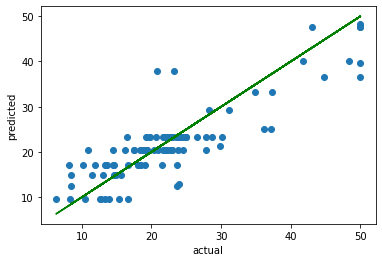

In [30]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test, color = "green")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test, y_test_pred)
plt.show()

We plot the predicted value of price of house on the y-axis and actual value on the x-axis. Ideally all the points should lie on the y = x line. We observe that most of the points lie close to the y = x line. We also observe that there are some horizonal lines in the plot implying same predicted value for a range of actual values. This is because we implemented a basic decision tree. We will see later that these horizontal lines disappear when we use more advanced techniques like the random-forest.

## Random Forests

Now we take a look at simple ensemble methods using decision trees. The most famous of these is the classical Random Forest, using Bagging / Random Subspace projection methods.

But, what is a _random forest_ ? A random forest is simply a collection of trees trained on random subsets of the data (either resampled data points and/or subset of attributes). Here is a picture of a 2-tree random forest:

![](https://github.com/mbrc12/random-images/raw/master/two-tree-random-forest.png)

Another question is, how do we actually _use_ this structure to generate predictions. In the simplest form, this prediction is simply done by averaging the answers from the trees. Note that we use averaging here because the problem we are solving is **regression** as opposed to **classification**.

Of course, this is not the only method that can be used. Other methods involve boosting trees, which train trees on the residual from other trees, but we do not delve into this matter here.

### Construction

Now let us take a look at how we construct these forests. The code for the algorithm described here is included below.

Firstly, note that we take the algorithm for Decision Trees as a black-box (in our code, we use the Decision Trees above). Given a training dataset, we form a fixed (hyperparameter) number of trees (_lines 21-30 below_). For each tree, we choose a resampled (with replacement) subset of the datapoints (_line 23_), _and_ a subset of the attributes (_line 24_). The size of these subsets are controlled by the hyperparameters. Then we train the tree on this data (_line 28_).

The first technique of using resampled data is very similar to the bootstrap method, and can also be used for **constructing <u>confidence intervals</u> for the answers**. It is also referred to as **bagging / bootstrap-aggregating** in the ensemble learning literature.

The second technique of choosing a random subset of the attributes is part of a generic technique for dealing with high-dimensional data, called **random subspace projection**. The name is so because choosing a particular set of attributes/coordinates is equivalent to projecting the high-dimensional datapoints to smaller subspaces.

**Note:** In our use-case we do not use random-subspace projection, because we have only a few attributes (~15), in which the projection method doesn't help much.

### Prediction

The prediction is implemented in lines _34-43_. It is a simple algorithm in our case: just average the answers from all the trees.

In [26]:
from numpy.random import choice, seed

class RandomForest:

    trees = []
    importance = None

    def __init__(self):
        self.trees = []

    def fit(self, X, y, num_trees = 1, frac_samples = None, frac_attrs = None):
        seed(0)
        
        N, total_attributes = X.shape 
        self.importance = np.zeros(total_attributes)

        if frac_samples == None:
            frac_samples = 1.0

        if frac_attrs == None:
            frac_attrs = 1.0

        for i in range(num_trees):
            new_tree = DecisionTree()
            sample = choice(range(N), size = int(N * frac_samples))
            attrs = choice(range(total_attributes), size = int(total_attributes * frac_attrs))
            #print(attrs, end=", ")
            dataset = X[sample, :]   #[:, attrs]
            ys = y[sample]
            new_tree.fit(dataset, ys, min_coef_of_var = 0.025, pruning_factor = 0)

            self.importance += new_tree.get_reductions()

            self.trees.append((new_tree, attrs))

        self.importance /= num_trees

    def predict(self, X):
        
        N, _ = X.shape 

        answer = np.zeros(N)

        for (t, attrs) in self.trees:
            answer += t.predict(X) # [:, attrs])
        
        return answer / len(self.trees)

Now, we train the random forest on our training data, using a 0.8 fraction of (resampled) data-points. However, we choose not to use to the projection method, for reasons described above.

In [27]:
rf = RandomForest()
rf.fit(X_train, y_train, num_trees = 30, frac_samples = 0.8, frac_attrs = 1.0)

And then we test it on our test-data.

In [28]:
y_test_rf = rf.predict(X_test)
y_test_rf
metrics.r2_score(y_test, y_test_rf)

0.8545010166573305

We see a really good improvement from the raw Decision Tree score (~72% to ~85%). Let us also compare it to the scikit-learn implementation (which is more advanced than ours):

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfsk = RandomForestRegressor(bootstrap=True)
rfsk.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_test_rfsk = rfsk.predict(X_test)
metrics.r2_score(y_test, y_test_rfsk)

0.9099455853887437

We see that scikit-learn manages an accuracy of ~91%. Our 85% is not that worse, given that our implementation is very bare-bones, and mostly proof-of-concept. This shows the power of the very idea of random forests (and in general, ensemble learning). 

Finally, we plot our predictions as opposed to the ground truth (x = y). 

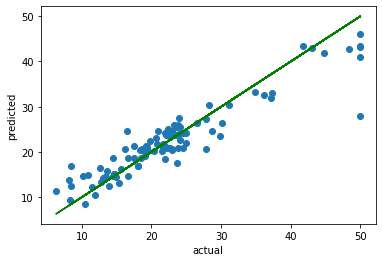

In [31]:
plt.plot(y_test, y_test, color = "green")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.scatter(y_test, y_test_rf)
plt.show()

We see that a large chunk of the predicted points is really close to the ground truths. Also, we observe no horizontal segments like in the case for Decision Trees. This is because of the averaging step in the Random Forests, and contributes immensely to the accuracy.

## Variable Importance

Now we take a look at the importance of variables. For this purpose, we compute the following quantity for each tree $T$ in the ensemble:

$\mathrm{VarReduction}_i = \sum_{x \in T} \mathrm{Optimal\ Variance\ Reduction\ in\ node\ } x \mathrm{\ by\ attribute\ } i$

and then denote 

$\mathrm{Importance}_i = \mathrm{Average\ of\ VarReduction}_i$

This quantity will be the importance of attribute $i$. We plot these quantities in a relative sense.


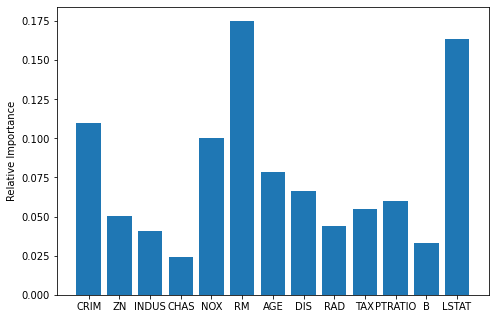

In [34]:
importance = rf.importance
relative_importance = importance / np.sum(importance)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(data.feature_names, relative_importance)
plt.ylabel('Relative Importance')
plt.show()

The following are the meanings of the attributes:

    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per $10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in $1000's


So we can see that the most important attribute is RM, which is the average number of rooms. This makes sense, because the number of rooms is an important factor. The 2nd most important factor is LSTAT, which is the percentage of the population which is of lower status. This can be interpreted to mean that the price is lower in underdeveloped regions. And the 3rd most important factor is crime rate (CRIM), which too makes a lot of sense. On the other end, the CHAS variable is about the Charles River. It doesn't make too much of an impact on the price.